### Импорт библиотек </br> Обеспечение воспроизводимости кода

In [ ]:
from google.colab import drive
import torch
import numpy as np
import random
import os

from google.colab import drive

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pickle
from PIL import Image
from torchvision import transforms

from matplotlib import colors, pyplot as plt
%matplotlib inline

from pathlib import Path

from sklearn.model_selection import train_test_split

from collections import Counter
import pandas as pd

import torch.nn as nn

from tqdm import tqdm

from sklearn.metrics import f1_score

In [ ]:
def set_seed(seed):
    torch.random.manual_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(7)

### Загрузка данных </br> Формирование обучающей, валидационной и тестовой выборок </br> Создание враппера над датасетом

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

Увеличим выборку данных для обучения, добавив следующие модификации:
* Переворот изображения по горизонтали с вероятностью 0.5 (RandomHorizontalFlip)
* Обрезка случайной части изображения и изменение ее размера до нужного с вероятностью 0.3 (RandomResizedCrop)

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
  
    def __getitem__(self, index):
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply(torch.nn.ModuleList([transforms.RandomResizedCrop(RESCALE_SIZE),]), p=0.3),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                  
        ])
        val_test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'train':
            x = train_transform(x)
        else:
            x = val_test_transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
len(train_val_files), len(test_files)

(20933, 991)

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [ ]:
characters_df = pd.DataFrame.from_dict(Counter(train_val_labels), orient='index')
characters_df.columns = ['Number of images']

In [ ]:
print('Всего жителей Спрингфилда:', len(characters_df))

Всего жителей Спрингфилда: 42


In [ ]:
print(characters_df.sort_values(by='Number of images', ascending=False))

                          Number of images
homer_simpson                         2246
ned_flanders                          1454
moe_szyslak                           1452
lisa_simpson                          1354
bart_simpson                          1342
marge_simpson                         1291
krusty_the_clown                      1206
principal_skinner                     1194
charles_montgomery_burns              1193
milhouse_van_houten                   1079
chief_wiggum                           986
abraham_grampa_simpson                 913
sideshow_bob                           877
apu_nahasapeemapetilon                 623
kent_brockman                          498
comic_book_guy                         469
edna_krabappel                         457
nelson_muntz                           358
lenny_leonard                          310
mayor_quimby                           246
waylon_smithers                        181
maggie_simpson                         128
groundskeep

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

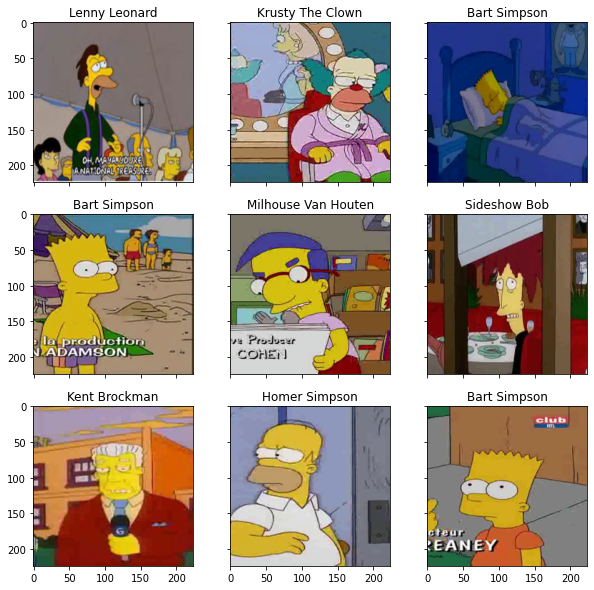

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

### Функции для обучения модели, оценки ее качества и выполнения предсказаний

In [ ]:
DEVICE = torch.device("cuda")

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step() 
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=6)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, 
                                           t_loss=train_loss, v_loss=val_loss, 
                                           t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def plot_loss_and_accuracy(train_loss, val_loss, train_accuracy, val_accuracy):
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_loss)), train_loss, label="train_loss")
    plt.plot(range(len(val_loss)), val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(len(train_accuracy)), train_accuracy, label="train_accuracy")
    plt.plot(range(len(val_accuracy)), val_accuracy, label="val_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")

In [ ]:
def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
def show_one_sample_prediction(model):
  i = int(np.random.uniform(0, len(val_dataset)))
  img, actual_class = val_dataset[i]
  probs = predict_one_sample(model, img.unsqueeze(0))
  actual_label = label_encoder.classes_[actual_class]
  pred_label = label_encoder.classes_[np.argmax(probs, -1)][0]
  fig, ax = plt.subplots(1, 1)
  imshow(img, title=f'actual: {actual_label} \npredicted: {pred_label}', plt_ax=ax)

In [ ]:
def show_some_predictions(model):
  fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(13, 13), sharey=True, sharex=True)
  for fig_x in ax.flatten():
      i = int(np.random.uniform(0, len(val_dataset)))
      img, actual_class = val_dataset[i]
      actual_label = label_encoder.classes_[actual_class]
      probs = predict_one_sample(model, img.unsqueeze(0))
      pred_proba = int(np.max(probs) * 100)
      pred_class = np.argmax(probs)
      pred_label = label_encoder.classes_[pred_class]
      img_label = f'actual: {actual_label} \npredicted: {pred_label} {pred_proba}%'
      imshow(img.data.cpu(), title=img_label, plt_ax=fig_x)

In [ ]:
def f1_for_val(model, val_dataset):
  model.eval()
  val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
  with torch.no_grad():
      logits = []
      actual_classes = []
      for inputs, labels in val_loader:
          inputs = inputs.to(DEVICE)
          outputs = model(inputs).cpu()
          logits.append(outputs)
          actual_classes.append(labels)
  probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
  pred_classes = np.argmax(probs, -1)
  actual_classes = torch.cat(actual_classes)
  return f1_score(actual_classes, pred_classes, average='micro')

### Сеть

Небольшие дополнения к изначальной архитектуре:
* Еще два полносвязных слоя
* BatchNorm после каждого слоя кроме двух последних
* Dropout с вероятностью 0.3 после первого полносвязного слоя 

In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 40 * 5 * 5),
            nn.BatchNorm1d(40 * 5 * 5),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(40 * 5 * 5, 40 * 5 * 5),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(40 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.fc3(x)
        return logits

И некоторые изменения/дополнения в обучении:
* Оптимизатор AdamW c learning rate равным 0.001
* 15 эпох
* Уменьшение learning rate в 0.1 раз каждые 6 эпох

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

history = train(train_dataset, val_dataset, model=simple_cnn, epochs=15, batch_size=64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.945650985517489


epoch:   7%|▋         | 1/15 [03:31<49:19, 211.41s/it]


Epoch 001 train_loss: 1.9457     val_loss 1.2281 train_acc 0.4725 val_acc 0.6620
loss 1.2993397789401182


epoch:  13%|█▎        | 2/15 [07:04<46:03, 212.55s/it]


Epoch 002 train_loss: 1.2993     val_loss 0.9127 train_acc 0.6413 val_acc 0.7384
loss 1.044156004345427


epoch:  20%|██        | 3/15 [10:34<42:12, 211.04s/it]


Epoch 003 train_loss: 1.0442     val_loss 0.7713 train_acc 0.7085 val_acc 0.7914
loss 0.892192407725867


epoch:  27%|██▋       | 4/15 [14:03<38:34, 210.36s/it]


Epoch 004 train_loss: 0.8922     val_loss 0.6357 train_acc 0.7511 val_acc 0.8208
loss 0.777754070257805


epoch:  33%|███▎      | 5/15 [17:33<35:01, 210.19s/it]


Epoch 005 train_loss: 0.7778     val_loss 0.6652 train_acc 0.7850 val_acc 0.8139
loss 0.6887776485005187


epoch:  40%|████      | 6/15 [21:03<31:32, 210.24s/it]


Epoch 006 train_loss: 0.6888     val_loss 0.5579 train_acc 0.8079 val_acc 0.8452
loss 0.5410605325266938


epoch:  47%|████▋     | 7/15 [24:34<28:04, 210.56s/it]


Epoch 007 train_loss: 0.5411     val_loss 0.4472 train_acc 0.8520 val_acc 0.8783
loss 0.48499940232859573


epoch:  53%|█████▎    | 8/15 [28:03<24:28, 209.85s/it]


Epoch 008 train_loss: 0.4850     val_loss 0.4253 train_acc 0.8672 val_acc 0.8859
loss 0.4656281758265189


epoch:  60%|██████    | 9/15 [31:31<20:56, 209.40s/it]


Epoch 009 train_loss: 0.4656     val_loss 0.4199 train_acc 0.8701 val_acc 0.8867
loss 0.43747192266238133


epoch:  67%|██████▋   | 10/15 [35:01<17:28, 209.67s/it]


Epoch 010 train_loss: 0.4375     val_loss 0.4207 train_acc 0.8785 val_acc 0.8886
loss 0.43919493392118414


epoch:  73%|███████▎  | 11/15 [38:30<13:57, 209.43s/it]


Epoch 011 train_loss: 0.4392     val_loss 0.4087 train_acc 0.8787 val_acc 0.8894
loss 0.43440602833780184


epoch:  80%|████████  | 12/15 [41:57<10:25, 208.62s/it]


Epoch 012 train_loss: 0.4344     val_loss 0.4006 train_acc 0.8827 val_acc 0.8907
loss 0.41280264609618905


epoch:  87%|████████▋ | 13/15 [45:21<06:54, 207.19s/it]


Epoch 013 train_loss: 0.4128     val_loss 0.3927 train_acc 0.8891 val_acc 0.8947
loss 0.41401449377023913


epoch:  93%|█████████▎| 14/15 [48:47<03:26, 206.95s/it]


Epoch 014 train_loss: 0.4140     val_loss 0.3907 train_acc 0.8882 val_acc 0.8951
loss 0.41873431735011724


epoch: 100%|██████████| 15/15 [52:12<00:00, 208.80s/it]


Epoch 015 train_loss: 0.4187     val_loss 0.3888 train_acc 0.8872 val_acc 0.8947


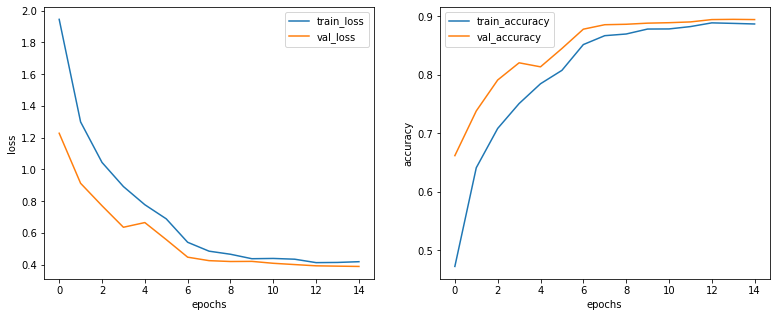

In [ ]:
train_loss, train_accuracy, val_loss, val_accuracy = zip(*history)
plot_loss_and_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

Получился очень даже хороший результат. Использование регуляризации позволило предотвратить переобучение.

In [ ]:
f1_for_val(simple_cnn, val_dataset)

0.8947267863966374

Учитывая, что валидационная выборка в 5 раз больше тестовой, вероятно, на тестовой значение метрики F1 будет еще лучше

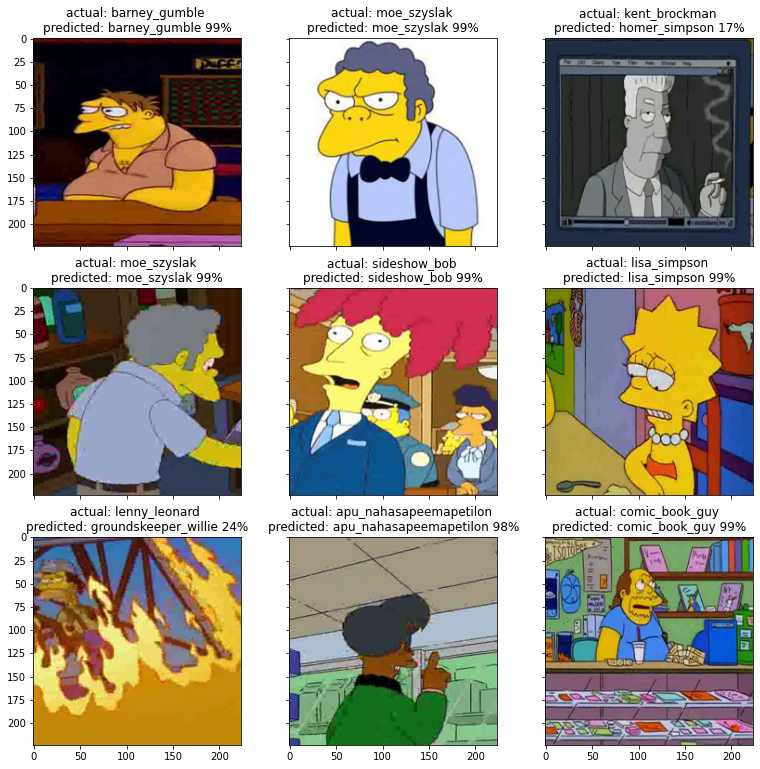

In [ ]:
show_some_predictions(simple_cnn)

### Финальный сабмит

Теперь обучим сеть на всем датасете

In [ ]:
n_classes = len(np.unique(train_val_labels))
final_cnn = SimpleCnn(n_classes).to(DEVICE)

train_val_dataset = SimpsonsDataset(train_val_files, mode='train')
train_val_loader = DataLoader(train_val_dataset, batch_size=64, shuffle=True)

In [ ]:
history_ = []
log_template = "\nEpoch {ep:03d} train_val_loss: {t_v_loss:0.4f} train_val_acc {t_v_acc:0.4f}"

with tqdm(desc="epoch", total=15) as pbar_outer:
    opt = torch.optim.AdamW(final_cnn.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=6)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(15):
        train_val_loss, train_val_acc = fit_epoch(final_cnn, train_val_loader, criterion, opt, scheduler)
        history_.append((train_val_loss, train_val_acc))
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_v_loss=train_val_loss, t_v_acc=train_val_acc))

epoch:   7%|▋         | 1/15 [03:44<52:28, 224.90s/it]


Epoch 001 train_val_loss: 1.8313 train_val_acc 0.5017


epoch:  13%|█▎        | 2/15 [07:27<48:29, 223.80s/it]


Epoch 002 train_val_loss: 1.1643 train_val_acc 0.6796


epoch:  20%|██        | 3/15 [11:11<44:42, 223.50s/it]


Epoch 003 train_val_loss: 0.9225 train_val_acc 0.7427


epoch:  27%|██▋       | 4/15 [14:52<40:49, 222.72s/it]


Epoch 004 train_val_loss: 0.8055 train_val_acc 0.7746


epoch:  33%|███▎      | 5/15 [18:33<37:01, 222.10s/it]


Epoch 005 train_val_loss: 0.7049 train_val_acc 0.8019


epoch:  40%|████      | 6/15 [22:02<32:39, 217.76s/it]


Epoch 006 train_val_loss: 0.6453 train_val_acc 0.8220


epoch:  47%|████▋     | 7/15 [25:35<28:49, 216.14s/it]


Epoch 007 train_val_loss: 0.4951 train_val_acc 0.8637


epoch:  53%|█████▎    | 8/15 [29:08<25:06, 215.22s/it]


Epoch 008 train_val_loss: 0.4473 train_val_acc 0.8785


epoch:  60%|██████    | 9/15 [32:45<21:34, 215.72s/it]


Epoch 009 train_val_loss: 0.4378 train_val_acc 0.8809


epoch:  67%|██████▋   | 10/15 [36:20<17:56, 215.27s/it]


Epoch 010 train_val_loss: 0.4266 train_val_acc 0.8834


epoch:  73%|███████▎  | 11/15 [39:56<14:22, 215.58s/it]


Epoch 011 train_val_loss: 0.4060 train_val_acc 0.8894


epoch:  80%|████████  | 12/15 [43:32<10:47, 215.84s/it]


Epoch 012 train_val_loss: 0.3971 train_val_acc 0.8922


epoch:  87%|████████▋ | 13/15 [47:10<07:12, 216.45s/it]


Epoch 013 train_val_loss: 0.3846 train_val_acc 0.8950


epoch:  93%|█████████▎| 14/15 [50:49<03:37, 217.06s/it]


Epoch 014 train_val_loss: 0.3851 train_val_acc 0.8943


epoch: 100%|██████████| 15/15 [54:25<00:00, 217.69s/it]


Epoch 015 train_val_loss: 0.3806 train_val_acc 0.8950


In [ ]:
torch.save(final_cnn, 'final_cnn_weights.pkl')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(final_cnn, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
final_submit = pd.read_csv('sample_submission.csv')
final_submit['Id'] = test_filenames
final_submit['Expected'] = preds
final_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
final_submit.to_csv('final_submit.csv', index=False)

F1-score: 0.97768